# Regression analysis with SVD decomposition for a real covariance and a fast system

In [1]:
import pandas as pd
import numpy as np
from numpy.random import multivariate_normal, normal
from numpy.linalg import cholesky, svd
from scipy.sparse.linalg import lsqr
from itertools import accumulate
from sklearn.linear_model import LinearRegression
from scipy.linalg import lstsq
from scipy.optimize import nnls

import pytest

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sandy
import serpentTools as sts

## Real covariance with same groups as the sensitivity (1000)

In [4]:
sens = sts.read("Godiva.i_sens0.m")

INFO:  Reading Godiva.i_sens0.m
INFO:    - done


In [5]:
nzai = sens.zais[922350]

sensitivity = {}
e = sens.energies

npert = sens.perts['capture xs']
s = sens.sensitivities["keff"][0, nzai, npert].T[0]
sensitivity["capture xs"] = pd.Series(s, index=e[1:])
npert = sens.perts['fission xs']
s = sens.sensitivities["keff"][0, nzai, npert].T[0]
sensitivity["fission xs"] = pd.Series(s, index=e[1:])
npert = sens.perts['ela scatt xs']
s = sens.sensitivities["keff"][0, nzai, npert].T[0]
sensitivity["ela scatt xs"] = pd.Series(s, index=e[1:])
npert = sens.perts['inl scatt xs']
s = sens.sensitivities["keff"][0, nzai, npert].T[0]
sensitivity["inl scatt xs"] = pd.Series(s, index=e[1:])

In [6]:
tape = sandy.get_endf6_file("jeff_33", "xs", 922350)
mt = [2, 4, 18, 102]
err = tape.get_errorr(err=1, xs=True, nubar=False, chi=False, mubar=False, errorr33_kws=dict(mt=mt, ek=e), verbose=True)["errorr33"]
cov = err.get_cov()

INFO:  Zero or no temperature was requested, NJOY processing will stop after RECONR.
    If you want to process 0K cross sections use `temperature=0.1`.
    


moder
20 -21 /
reconr
-21 -22 /
'sandy runs njoy'/
9228 0 0 /
1.0 0. /
0/
moder
-22 30 /
errorr
-21 -22 0 33 0 /
9228 1 2 0 1 /
0 0.0 /
1 33 0/
4 0 /
2 4 18 102 /
1000 /
1.00000e-07 1.01930e-07 1.03897e-07 1.05902e-07 1.07945e-07 1.10028e-07 1.12152e-07 1.14316e-07 1.16522e-07 1.18771e-07 1.21063e-07 1.23399e-07 1.25780e-07 1.28207e-07 1.30682e-07 1.33203e-07 1.35774e-07 1.38394e-07 1.41065e-07 1.43787e-07 1.46562e-07 1.49390e-07 1.52273e-07 1.55211e-07 1.58207e-07 1.61260e-07 1.64372e-07 1.67544e-07 1.70777e-07 1.74072e-07 1.77432e-07 1.80856e-07 1.84346e-07 1.87903e-07 1.91529e-07 1.95225e-07 1.98993e-07 2.02833e-07 2.06747e-07 2.10737e-07 2.14803e-07 2.18949e-07 2.23174e-07 2.27481e-07 2.31870e-07 2.36345e-07 2.40906e-07 2.45555e-07 2.50293e-07 2.55124e-07 2.60047e-07 2.65065e-07 2.70180e-07 2.75394e-07 2.80709e-07 2.86126e-07 2.91647e-07 2.97275e-07 3.03012e-07 3.08859e-07 3.14820e-07 3.20895e-07 3.27087e-07 3.33399e-07 3.39833e-07 3.46391e-07 3.53076e-07 3.59889e-07 3.66834e-07 3.

C:\Users\lfiorito\Desktop\sandy\sandy\core\endf6.py:962: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [8]:
C = cov.data.copy()
#print(f"condition number original matrix: {np.linalg.cond(C):>10}")
C = pd.DataFrame(C.values + np.diag(np.diag(C.values) * 0.5 / 100 + 0.0001), index=C.index, columns=C.columns)
#print(f"condition number adjusted matrix: {np.linalg.cond(C):>10}")
cov_ = sandy.CategoryCov(C)

In [9]:
U, S, V = svd(C)
Lambda12 = np.diag(np.sqrt(S))

In [10]:
np.testing.assert_almost_equal((U @ Lambda12) @ (U @ Lambda12).T, C.values)

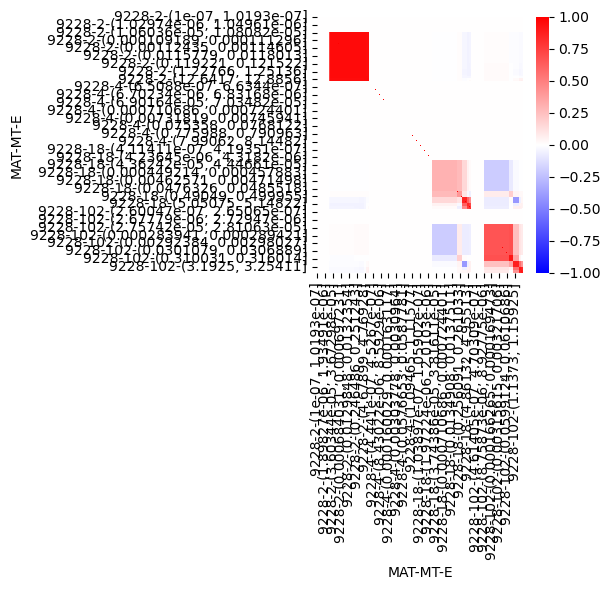

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cov_.get_corr().data, ax=ax, cmap="bwr", vmin=-1, vmax=1)
fig.tight_layout()

In [11]:
M = cov.data.shape[0]  # number of parameters

frac = S / S.sum()
acc = np.array(list(accumulate(frac)))
r = acc[acc < 0.98].size + 1

N = 5000  # number of samples

print(f"sample size:                  {N:>10}\nnumber of parameters:         {M:>10}\nreduced number of parameters: {r:>10}")

sample size:                        5000
number of parameters:               4000
reduced number of parameters:       3450


In [13]:
# non correlated, standardized sample
X_ = normal(loc=1., scale=1., size=N * M).reshape(N, M)

# correlated sample
X = X_ @ (U @ Lambda12).T

In [24]:
def model1(x): return sensitivity["capture xs"] @ x
def model2(x): return sensitivity["fission xs"] @ x
def model3(x): return sensitivity["ela scatt xs"] @ x
def model4(x): return sensitivity["inl scatt xs"] @ x

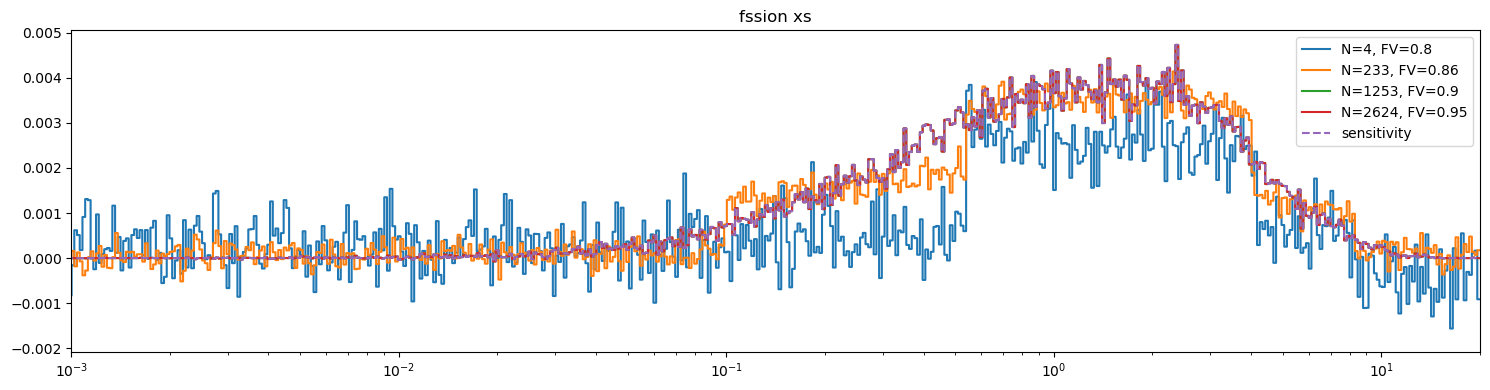

In [70]:
fig, ax = plt.subplots(figsize=(15, 4))

model = model1

data = {}
for fv in np.array([0.8, 0.86, 0.9, 0.95]):
    n = acc[acc < fv].size + 1
    Y = model(X[:n, (e.size - 1)*2:(e.size - 1)*3].T)
    Z = lstsq(X[:n, (e.size - 1)*2:(e.size - 1)*3], Y)[0]
    data[f"N={n}, FV={fv}"] = Z

# Y = model(X[:, (e.size - 1)*0:(e.size - 1)*1].T)
# Z = lstsq(X[:, (e.size - 1)*0:(e.size - 1)*1], Y)[0]
# data[f"N={N}"] = Z

pd.DataFrame(data, index=e[1:]).plot(kind="line", ax=ax, logx=True, drawstyle="steps-pre")
sensitivity["capture xs"].plot(ax=ax, label="sensitivity", ls="--", drawstyle="steps-pre")
ax.legend()

ax.set(xlim=[1e-3, 20], title="fssion xs")

fig.tight_layout()

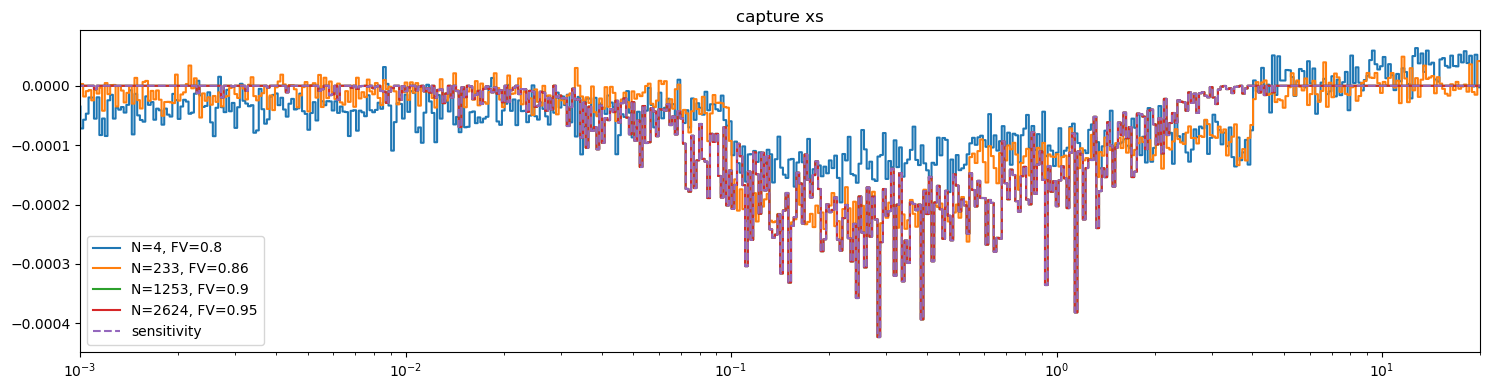

In [71]:
fig, ax = plt.subplots(figsize=(15, 4))

model = model2

data = {}
for fv in np.array([0.8, 0.86, 0.9, 0.95]):
    n = acc[acc < fv].size + 1
    Y = model(X[:n, (e.size - 1)*3:(e.size - 1)*4].T)
    Z = lstsq(X[:n, (e.size - 1)*3:(e.size - 1)*4], Y)[0]
    data[f"N={n}, FV={fv}"] = Z

# Y = model(X[:, (e.size - 1)*1:(e.size - 1)*2].T)
# Z = lstsq(X[:, (e.size - 1)*1:(e.size - 1)*2], Y)[0]
# data[f"N={N}"] = Z

pd.DataFrame(data, index=e[1:]).plot(kind="line", ax=ax, logx=True, drawstyle="steps-pre")
sensitivity["fission xs"].plot(ax=ax, label="sensitivity", ls="--", drawstyle="steps-pre")
ax.legend()

ax.set(xlim=[1e-3, 20], title="capture xs")

fig.tight_layout()

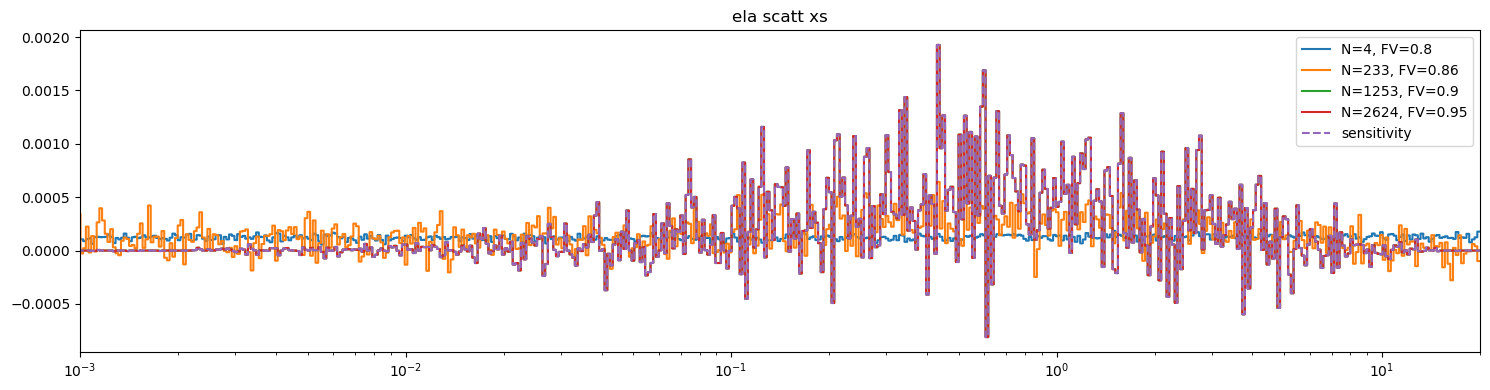

In [74]:
fig, ax = plt.subplots(figsize=(15, 4))

model = model3

data = {}
for fv in np.array([0.8, 0.86, 0.9, 0.95]):
    n = acc[acc < fv].size + 1
    Y = model(X[:n, (e.size - 1)*0:(e.size - 1)*1].T)
    Z = lstsq(X[:n, (e.size - 1)*0:(e.size - 1)*1], Y)[0]
    data[f"N={n}, FV={fv}"] = Z

# Y = model(X[:, (e.size - 1)*2:(e.size - 1)*3].T)
# Z = lstsq(X[:, (e.size - 1)*2:(e.size - 1)*3], Y)[0]
# data[f"N={N}"] = Z

pd.DataFrame(data, index=e[1:]).plot(kind="line", ax=ax, logx=True, drawstyle="steps-pre")
sensitivity["ela scatt xs"].plot(ax=ax, label="sensitivity", ls="--", drawstyle="steps-pre")
ax.legend()

ax.set(xlim=[1e-3, 20], title="ela scatt xs")

fig.tight_layout()

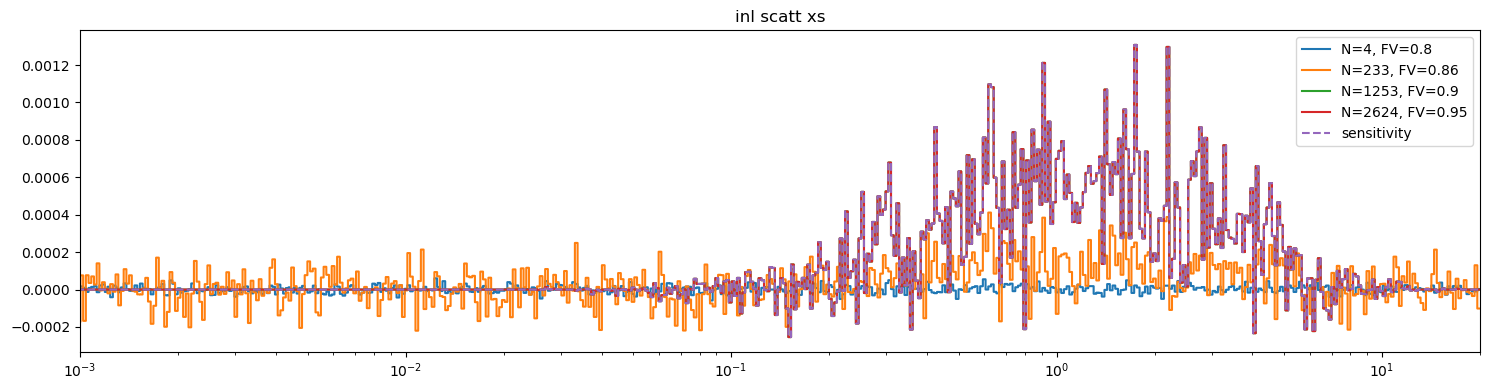

In [73]:
fig, ax = plt.subplots(figsize=(15, 4))

model = model4

data = {}
for fv in np.array([0.8, 0.86, 0.9, 0.95]):
    n = acc[acc < fv].size + 1
    Y = model(X[:n, (e.size - 1)*1:(e.size - 1)*2].T)
    Z = lstsq(X[:n, (e.size - 1)*1:(e.size - 1)*2], Y)[0]
    data[f"N={n}, FV={fv}"] = Z

# Y = model(X[:, (e.size - 1)*3:(e.size - 1)*4].T)
# Z = lstsq(X[:, (e.size - 1)*3:(e.size - 1)*4], Y)[0]
# data[f"N={N}"] = Z

pd.DataFrame(data, index=e[1:]).plot(kind="line", ax=ax, logx=True, drawstyle="steps-pre")
sensitivity["inl scatt xs"].plot(ax=ax, label="sensitivity", ls="--", drawstyle="steps-pre")
ax.legend()

ax.set(xlim=[1e-3, 20], title="inl scatt xs")

fig.tight_layout()